<a href="https://colab.research.google.com/github/siddharth3444/detect_window/blob/main/Instance_Segmentation_30_07_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install accelerate optuna torch-summary wandb 'albumentations>=1.4.5' timm datasets torchmetrics pycocotools evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
!python train.py --report_to=wandb --do_reduce_labels true --model_name_or_path qubvel-hf/finetune-instance-segmentation-ade20k-mini-mask2former --output_dir output --dataset_name piyyush1219/InstanceDataset --do_reduce_labels --image_height 512 --image_width 512  --do_train --fp16 --num_train_epochs 50 --learning_rate 9.971930719778446e-05 --weight_decay 0.00019277664635316874 --lr_scheduler_type constant --per_device_train_batch_size 8  --per_device_eval_batch_size 8 --gradient_accumulation_steps 2 --dataloader_num_workers 8 --dataloader_persistent_workers --dataloader_prefetch_factor 4 --do_eval --evaluation_strategy epoch --logging_strategy epoch --save_strategy epoch --save_total_limit 2


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:datasets:PyTorch version 2.3.1+cu121 available.
INFO:datasets:Polars version 0.20.2 available.
INFO:datasets:TensorFlow version 2.15.0 available.
INFO:datasets:JAX version 0.4.26 available.
2024-07-30 14:52:31.961050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 14:52:31.961102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 14:52:31.963114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBL

In [ ]:
!pip install -r requirements.txt

In [ ]:
import logging
import os
import sys
from dataclasses import dataclass, field
from functools import partial
from typing import Any, Dict, List, Mapping, Optional

import albumentations as A
import numpy as np
import torch
from datasets import load_dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import transformers
from transformers import (
    AutoImageProcessor,
    AutoModelForUniversalSegmentation,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    MaskFormerImageProcessor
)
from transformers.image_processing_utils import BatchFeature
from transformers.trainer import EvalPrediction
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version



In [ ]:
"""
  Config Vars
"""

model_name_or_path="facebook/maskformer-swin-large-ade"
dataset_name="piyyush1219/InstanceDataset"
trust_remote_code=True
do_reduce_labels=True
do_train=True
do_eval= True
push_to_hub=False
image_width=512
image_height=512

In [ ]:
##Testing
dataset={}
dx = load_dataset("qubvel-hf/ade20k-mini", split='train[:30]')
train_val_split = dx.train_test_split(test_size=0.1)
dataset["train"] = train_val_split["train"]
dataset["validate"] = train_val_split["test"]

print(train_val_split)

label2id = dataset["train"][0]["semantic_class_to_id"]
if do_reduce_labels:
    label2id = {name: idx for name, idx in label2id.items() if idx != 0}  # remove background class
    label2id = {name: idx - 1 for name, idx in label2id.items()}  # shift class indices by -1

id2label = {v: k for k, v in label2id.items()}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'annotation', 'semantic_class_to_id'],
        num_rows: 27
    })
    test: Dataset({
        features: ['image', 'annotation', 'semantic_class_to_id'],
        num_rows: 3
    })
})


In [ ]:
"""
Loading Dataset
"""
dataset={}
d = load_dataset(dataset_name, split='train[:30]')
train_val_split = d.train_test_split(test_size=0.1)
dataset["train"] = train_val_split["train"]
dataset["validate"] = train_val_split["test"]

label2id = dataset["train"][0]["semantic_class_to_id"]
print(label2id)
if do_reduce_labels:
    label2id = {name: idx for name, idx in label2id.items() if idx != 0}  # remove background class
    label2id = {name: idx - 1 for name, idx in label2id.items()}  # shift class indices by -1

id2label = {v: k for k, v in label2id.items()}

print(id2label)
print(label2id)


{'blinds': 3, 'curtain': 4, 'door': 2, 'floor': 1, 'wall': 0, 'windowpane': 5}
{2: 'blinds', 3: 'curtain', 1: 'door', 0: 'floor', 4: 'windowpane'}
{'blinds': 2, 'curtain': 3, 'door': 1, 'floor': 0, 'windowpane': 4}


In [ ]:
"""
  Loading Model and Preprocessor

"""
model = AutoModelForUniversalSegmentation.from_pretrained(
        model_name_or_path,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True
  )

image_processor = AutoImageProcessor.from_pretrained(
      model_name_or_path,
      do_resize=do_reduce_labels,
      size={"height": image_height, "width": image_width},
      do_reduce_labels=do_reduce_labels,
      reduce_labels=do_reduce_labels,  # TODO: remove when mask2former support `do_reduce_labels`
  )

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-large-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([6]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


In [ ]:
"""
Dataclass and Evaluation Class
"""
import evaluate

d_t=None
pd=None
fl=None
t=None
metric = evaluate.load("mean_iou", cache_dir='./cache')

def nested_cpu(tensors):
    if isinstance(tensors, (list, tuple)):
        return type(tensors)(nested_cpu(t) for t in tensors)
    elif isinstance(tensors, Mapping):
        return type(tensors)({k: nested_cpu(t) for k, t in tensors.items()})
    elif isinstance(tensors, torch.Tensor):
        return tensors.cpu().detach()
    else:
        return tensors

@dataclass
class Arguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    Using `HfArgumentParser` we can turn this class into argparse arguments to be able to specify
    them on the command line.
    """

    model_name_or_path: str = field(
        default="facebook/mask2former-swin-tiny-coco-instance",
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"},
    )
    dataset_name: str = field(
        default="qubvel-hf/ade20k-mini",
        metadata={
            "help": "Name of a dataset from the hub (could be your own, possibly private dataset hosted on the hub)."
        },
    )
    trust_remote_code: bool = field(
        default=False,
        metadata={
            "help": (
                "Whether to trust the execution of code from datasets/models defined on the Hub."
                " This option should only be set to `True` for repositories you trust and in which you have read the"
                " code, as it will execute code present on the Hub on your local machine."
            )
        },
    )
    image_height: Optional[int] = field(default=512, metadata={"help": "Image height after resizing."})
    image_width: Optional[int] = field(default=512, metadata={"help": "Image width after resizing."})
    token: str = field(
        default=None,
        metadata={
            "help": (
                "The token to use as HTTP bearer authorization for remote files. If not specified, will use the token "
                "generated when running `huggingface-cli login` (stored in `~/.huggingface`)."
            )
        },
    )
    do_reduce_labels: bool = field(
        default=False,
        metadata={
            "help": (
                "If background class is labeled as 0 and you want to remove it from the labels, set this flag to True."
            )
        },
    )

@dataclass
class ModelOutput:
    class_queries_logits: torch.Tensor
    masks_queries_logits: torch.Tensor

class Evaluator:
    """
    Compute metrics for the instance segmentation task.
    """

    def __init__(
        self,
        image_processor: AutoImageProcessor,
        id2label: Mapping[int, str],
        threshold: float = 0.0,
    ):
        """
        Initialize evaluator with image processor, id2label mapping and threshold for filtering predictions.

        Args:
            image_processor (AutoImageProcessor): Image processor for
                `post_process_instance_segmentation` method.
            id2label (Mapping[int, str]): Mapping from class id to class name.
            threshold (float): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        """
        self.image_processor = image_processor
        self.id2label = id2label
        self.threshold = threshold
        self.metric = self.get_metric()

    def get_metric(self):
        metric = MeanAveragePrecision(iou_type="segm", class_metrics=True)
        return metric

    def compute_pixel_accuracy(self,pred_masks, true_masks):
      pred_masks = pred_masks.flatten()
      true_masks = true_masks.flatten()
      correct = (pred_masks == true_masks).sum().item()
      total = len(pred_masks)
      accuracy = correct / total
      return accuracy

    def reset_metric(self):
        self.metric.reset()

    def postprocess_target_batch(self, target_batch) -> List[Dict[str, torch.Tensor]]:
        """Collect targets in a form of list of dictionaries with keys "masks", "labels"."""
        batch_masks = target_batch[0]
        batch_labels = target_batch[1]
        post_processed_targets = []
        for masks, labels in zip(batch_masks, batch_labels):
            global d_t
            d_t=masks
            masks=torch.tensor(masks)
            labels=torch.tensor(labels)
            post_processed_targets.append(
                {
                    "masks": masks.to(dtype=torch.bool),
                    "labels": labels,
                }
            )
        return post_processed_targets

    def get_target_sizes(self, post_processed_targets) -> List[List[int]]:
        target_sizes = []
        for target in post_processed_targets:
            target_sizes.append(target["masks"].shape[-2:])
        return target_sizes

    def postprocess_pred_semantic(self, prediction_batch, target_sizes):
        model_output = ModelOutput(class_queries_logits=torch.tensor(pd[0]), masks_queries_logits=torch.tensor(pd[1]))
        output=image_processor.post_process_semantic_segmentation(model_output,target_sizes=target_sizes)
        return output

    def postprocess_prediction_batch(self, prediction_batch, target_sizes) -> List[Dict[str, torch.Tensor]]:
        """Collect predictions in a form of list of dictionaries with keys "masks", "labels", "scores"."""
        global pd
        global s
        s=target_sizes
        pd=prediction_batch
        model_output = ModelOutput(class_queries_logits=torch.tensor(prediction_batch[0]), masks_queries_logits=torch.tensor(prediction_batch[1]))
        post_processed_output = self.image_processor.post_process_instance_segmentation(
            model_output,
            threshold=self.threshold,
            target_sizes=target_sizes,
            return_binary_maps=True,
        )

        post_processed_predictions = []
        for image_predictions, target_size in zip(post_processed_output, target_sizes):
            if image_predictions["segments_info"]:
                post_processed_image_prediction = {
                    "masks": image_predictions["segmentation"].to(dtype=torch.bool),
                    "labels": torch.tensor([x["label_id"] for x in image_predictions["segments_info"]]),
                    "scores": torch.tensor([x["score"] for x in image_predictions["segments_info"]]),
                }
            else:
                # for void predictions, we need to provide empty tensors
                post_processed_image_prediction = {
                    "masks": torch.zeros([0, *target_size], dtype=torch.bool),
                    "labels": torch.tensor([]),
                    "scores": torch.tensor([]),
                }
            post_processed_predictions.append(post_processed_image_prediction)

        return post_processed_predictions



    @torch.no_grad()
    def __call__(self, evaluation_results: EvalPrediction, compute_result: bool = False) -> Mapping[str, float]:
        """
        Update metrics with current evaluation results and return metrics if `compute_result` is True.

        Args:
            evaluation_results (EvalPrediction): Predictions and targets from evaluation.
            compute_result (bool): Whether to compute and return metrics.

        Returns:
            Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
        """
        prediction_batch = nested_cpu(evaluation_results.predictions)
        target_batch = nested_cpu(evaluation_results.label_ids)
        global t
        t=evaluation_results

        # For metric computation we need to provide:
        #  - targets in a form of list of dictionaries with keys "masks", "labels"
        #  - predictions in a form of list of dictionaries with keys "masks", "labels", "scores"
        post_processed_targets = self.postprocess_target_batch(target_batch)
        target_sizes = self.get_target_sizes(post_processed_targets)
        post_processed_predictions = self.postprocess_prediction_batch(prediction_batch, target_sizes)
        global fl

        # Compute metrics
        self.metric.update(post_processed_predictions, post_processed_targets)
        pred_masks = self.postprocess_pred_semantic(prediction_batch, target_sizes)
        true_masks = torch.cat([gt['labels'] for gt in post_processed_targets], dim=0)
        fl={"pred_masks":pred_masks,"true_masks":true_masks}

        if not compute_result:
            return {}

        metrics = self.metric.compute()
        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = self.id2label[class_id.item()] if self.id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        # Reset metric for next evaluation
        self.reset_metric()

        return metrics

In [ ]:
"""
  Set of defined Resuable function
"""

def setup_logging(training_args: TrainingArguments) -> None:
    """Setup logging according to `training_args`."""

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )

    if training_args.should_log:
        # The default of training_args.log_level is passive, so we set log level at info here to have that default.
        transformers.utils.logging.set_verbosity_info()

    log_level = training_args.get_process_log_level()
    logger.setLevel(log_level)
    transformers.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()

def find_last_checkpoint(training_args: TrainingArguments) -> Optional[str]:
    """Find the last checkpoint in the output directory according to parameters specified in `training_args`."""

    checkpoint = None
    if training_args.resume_from_checkpoint is not None:
        checkpoint = training_args.resume_from_checkpoint
    elif os.path.isdir(training_args.output_dir) and not training_args.overwrite_output_dir:
        checkpoint = get_last_checkpoint(training_args.output_dir)
        if checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
            raise ValueError(
                f"Output directory ({training_args.output_dir}) already exists and is not empty. "
                "Use --overwrite_output_dir to overcome."
            )
        elif checkpoint is not None and training_args.resume_from_checkpoint is None:
            logger.info(
                f"Checkpoint detected, resuming training at {checkpoint}. To avoid this behavior, change "
                "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
            )

    return checkpoint

def augment_and_transform_batch(
    examples: Mapping[str, Any], transform: A.Compose, image_processor: AutoImageProcessor
) -> BatchFeature:
    batch = {
        "pixel_values": [],
        "mask_labels": [],
        "class_labels": [],
    }

    for pil_image, pil_annotation in zip(examples["image"], examples["annotation"]):
        image = np.array(pil_image)
        semantic_and_instance_masks = np.array(pil_annotation)[..., :2]

        # Apply augmentations
        #transform.is_check_shapes = False
        output = transform(image=image, mask=semantic_and_instance_masks)

        aug_image = output["image"]
        aug_semantic_and_instance_masks = output["mask"]
        aug_instance_mask = aug_semantic_and_instance_masks[..., 1]

        # Create mapping from instance id to semantic id
        unique_semantic_id_instance_id_pairs = np.unique(aug_semantic_and_instance_masks.reshape(-1, 2), axis=0)
        instance_id_to_semantic_id = {
            instance_id: semantic_id for semantic_id, instance_id in unique_semantic_id_instance_id_pairs
        }

        # Apply the image processor transformations: resizing, rescaling, normalization
        model_inputs = image_processor(
            images=[aug_image],
            segmentation_maps=[aug_instance_mask],
            instance_id_to_semantic_id=instance_id_to_semantic_id,
            return_tensors="pt",
        )

        batch["pixel_values"].append(model_inputs.pixel_values[0])
        batch["mask_labels"].append(model_inputs.mask_labels[0])
        batch["class_labels"].append(model_inputs.class_labels[0])

    return batch

def collate_fn(examples):
    batch = {}
    batch["pixel_values"] = torch.stack([example["pixel_values"] for example in examples])
    batch["class_labels"] = [example["class_labels"] for example in examples]
    batch["mask_labels"] = [example["mask_labels"] for example in examples]
    if "pixel_mask" in examples[0]:
        batch["pixel_mask"] = torch.stack([example["pixel_mask"] for example in examples])
    return batch

In [ ]:
def augment_and_transform_batch(
    examples: Mapping[str, Any], transform: A.Compose, image_processor: AutoImageProcessor
) -> BatchFeature:
    batch = {
        "pixel_values": [],
        "mask_labels": [],
        "class_labels": [],
    }

    for pil_image, pil_annotation in zip(examples["image"], examples["annotation"]):
        image = np.array(pil_image)
        semantic_and_instance_masks = np.array(pil_annotation)[..., :2]

        # Apply augmentations
        output = transform(image=image, mask=semantic_and_instance_masks)

        aug_image = output["image"]
        aug_semantic_and_instance_masks = output["mask"]
        aug_instance_mask = aug_semantic_and_instance_masks[..., 1]

        # Create mapping from instance id to semantic id
        unique_semantic_id_instance_id_pairs = np.unique(aug_semantic_and_instance_masks.reshape(-1, 2), axis=0)
        instance_id_to_semantic_id = {
            instance_id: semantic_id for semantic_id, instance_id in unique_semantic_id_instance_id_pairs
        }

        # Apply the image processor transformations: resizing, rescaling, normalization
        model_inputs = image_processor(
            images=[aug_image],
            segmentation_maps=[aug_instance_mask],
            instance_id_to_semantic_id=instance_id_to_semantic_id,
            return_tensors="pt",
        )

        batch["pixel_values"].append(model_inputs.pixel_values[0])
        batch["mask_labels"].append(model_inputs.mask_labels[0])
        batch["class_labels"].append(model_inputs.class_labels[0])

    return batch

In [ ]:
parser = HfArgumentParser([Arguments, TrainingArguments])
#args, training_args = parser.parse_args_into_dataclasses()
# training_args.eval_do_concat_batches = False
# training_args.batch_eval_metrics = True
# training_args.remove_unused_columns = False
# send_example_telemetry("run_instance_segmentation", args)
# setup_logging(training_args)
# logger.warning(
#     f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}, "
#     + f"distributed training: {training_args.parallel_mode.value == 'distributed'}, 16-bits training: {training_args.fp16}"
# )
# logger.info(f"Training/evaluation parameters {training_args}")
# checkpoint = find_last_checkpoint(training_args)


In [ ]:
"""
Training Model and Creating desired Data
"""
# ------------------------------------------------------------------------------------------------
# Define image augmentations and dataset transforms
# ------------------------------------------------------------------------------------------------
# Define the mean and std for normalization
ADE_MEAN = (123.675 / 255, 116.280 / 255, 103.530 / 255)
ADE_STD = (58.395 / 255, 57.120 / 255, 57.375 / 255)

def clip_values(image: np.ndarray, **kwargs) -> np.ndarray:
    return np.clip(image, 0.0, 1.0)


from albumentations.pytorch import ToTensorV2
# Define image augmentations and dataset transforms for instance segmentation
train_augment_and_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
        # A.Normalize(mean=ADE_MEAN, std=ADE_STD),
        A.Lambda(image=clip_values),
        ToTensorV2()  # Ensure that the output is in the format expected by the model
    ]
)

validation_transform = A.Compose(
    [
        A.NoOp(),
       # A.Normalize(mean=ADE_MEAN, std=ADE_STD),
        A.Lambda(image=clip_values),
        ToTensorV2()
    ]
)
processor = MaskFormerImageProcessor(do_reduce_labels=True,ignore_index=255, do_resize=False, do_rescale=False, do_normalize=True)
# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

dataset["train"] = dataset["train"].with_transform(train_transform_batch)
dataset["validate"] = dataset["validate"].with_transform(validation_transform_batch)

In [ ]:
print(len(dataset['train']))
print(len(dataset['validate']))

27
3


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

43

In [ ]:


# ------------------------------------------------------------------------------------------------
# Model training and evaluation with Trainer API
# ------------------------------------------------------------------------------------------------
from transformers import EarlyStoppingCallback


def model_init(trial=None):
    global label2id
    global id2label
    global model_name_or_path

    model = AutoModelForUniversalSegmentation.from_pretrained(
          model_name_or_path,
          label2id=label2id,
          id2label=id2label,
          ignore_mismatched_sizes=True
    )
    return model


def optuna_hp_space(trial):
      return {
        "learning_rate" :trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size" : trial.suggest_categorical("per_device_train_batch_size", [2]),
        "per_device_eval_batch_size" :trial.suggest_categorical("per_device_eval_batch_size", [2]),
        "weight_decay" : trial.suggest_float("weight_decay", 0.0, 0.3),
        "num_train_epochs" : trial.suggest_int("num_train_epochs", 3, 10),
        "warmup_steps" : trial.suggest_int("warmup_steps", 0, 500),
        "gradient_accumulation_steps" : trial.suggest_int("gradient_accumulation_steps", 1, 4),
        "lr_scheduler_type" : trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "constant"]),
      }

compute_metrics = Evaluator(image_processor=image_processor, id2label=id2label, threshold=0.0)
training_args = TrainingArguments(
  output_dir="./output_new",
  overwrite_output_dir =True,
  save_strategy="epoch",
  evaluation_strategy="epoch",
  # num_train_epochs=100,
  save_total_limit=1,
  #gradient_accumulation_steps=4,
#  gradient_checkpointing=True,
  # per_device_train_batch_size=4,
  # per_device_eval_batch_size=4,
  eval_steps=1 ,
  save_steps =4,
  fp16=True,
  report_to="wandb",
  logging_steps =4,
  load_best_model_at_end =True,
  remove_unused_columns=False,
  batch_eval_metrics =True
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"] if do_train else None,
    eval_dataset=dataset["validate"] if do_eval else None,
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)




early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluations with no improvement after which training will be stopped
    early_stopping_threshold=0.01  # The improvement threshold to qualify as a significant change
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-large-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([6]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
best_run = trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=25
)

[I 2024-07-28 18:08:40,472] A new study created in memory with name: no-name-33b39265-93f2-4473-82fe-1d6af4d5efae
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-large-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([6]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: siddharthgupta2451. Use `wandb login --relogin` to force relogin


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Floor,Mar 100 Floor,Map Door,Mar 100 Door,Map Blinds,Mar 100 Blinds,Map Curtain,Mar 100 Curtain,Map Windowpane,Mar 100 Windowpane
1,3.338900,3.245341,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.769400,2.989354,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.633500,2.696401,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2.590100,2.543421,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2.648000,2.473704,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,No Log,No Log,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<ipython-input-6-b2420c8d63eb>:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks=torch.tensor(masks)
<ipython-input-6-b2420c8d63eb>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels)
<ipython-input-6-b2420c8d63eb>:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_output = ModelOutput(class_queries_logits=torch.tensor(prediction_batch[0]), masks_queries_logits=torch.tensor(prediction_batch[1]))
<ipython-input-6-b2420c8d63eb>:140: UserWarning: To copy construct from a tensor, it is recommended to us

KeyboardInterrupt: 

In [ ]:
s

[torch.Size([256, 256]), torch.Size([256, 256]), torch.Size([256, 256])]

In [ ]:
# Training

checkpoint = find_last_checkpoint(training_args)

if do_train:
    train_result = trainer.train()
    trainer.save_model()
    trainer.log_metrics("train", train_result.metrics)
    trainer.save_metrics("train", train_result.metrics)
    trainer.save_state()

# Final evaluation
# if do_eval:
#     metrics = trainer.evaluate(eval_dataset=dataset["validation"], metric_key_prefix="test")
#     trainer.log_metrics("test", metrics)
#     trainer.save_metrics("test", metrics)

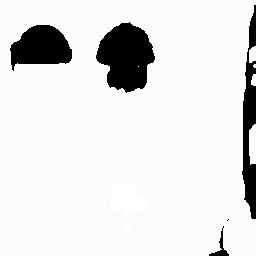

In [ ]:
from PIL import Image
x=t.label_ids[0][0][0].cpu().detach()

#print(t.label_ids)
mask=fl['pred_masks'][1].numpy()
# print(torch.tensor(fl['pred_masks']))
# #print(fl['true_masks'])

visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

In [ ]:
type(pd)
model_output = ModelOutput(class_queries_logits=torch.tensor(pd[0]), masks_queries_logits=torch.tensor(pd[1]))
op=image_processor.post_process_semantic_segmentation(model_output)
type(op)

<ipython-input-41-0a695ebf2492>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_output = ModelOutput(class_queries_logits=torch.tensor(pd[0]), masks_queries_logits=torch.tensor(pd[1]))


list